In [ ]:
import os, pathlib, shutil, random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Read in the csv file, split data into training, validation, and testing. Normalize the raw data.

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/Colab\ Notebooks/Project\ 2/

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Project 2


In [ ]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f: data = f.read();

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

raw_data -= raw_data[:num_train_samples].mean(axis=0)
raw_data /= raw_data[:num_train_samples].std(axis=0)

Define simple method to cut training, validation, and testing datasets.

In [ ]:
def create_datasets(sampling_rate, sequence_length, delay, batch_size):
    train_dataset = keras.utils.timeseries_dataset_from_array(
        raw_data[:-delay],
        targets=temperature[delay:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=0,
        end_index=num_train_samples
    )

    val_dataset = keras.utils.timeseries_dataset_from_array(
        raw_data[:-delay],
        targets=temperature[delay:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=num_train_samples,
        end_index=num_train_samples + num_val_samples
    )

    test_dataset = keras.utils.timeseries_dataset_from_array(
        raw_data[:-delay],
        targets=temperature[delay:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=num_train_samples + num_val_samples
    )

    return train_dataset, val_dataset, test_dataset

Create the datasets based on the parameters needed to get samples for ten days, hourly and half-hourly, and setup the delay so that the target is both 1 day after and 2 days after.

In [ ]:
hourly_sampling_rate = 6       #Take one sample per hour. (Data points are every ten minutes.)
hourly_sequence_length = 240   #Ten days worth of samples for hourly samples.
hourly_delay = hourly_sampling_rate * (hourly_sequence_length + 24 - 1)  #Targets will be set the same hour next day after target.
batch_size = 256

hourly_train_dataset, hourly_val_dataset, hourly_test_dataset = create_datasets(hourly_sampling_rate,
                                                                                hourly_sequence_length,
                                                                                hourly_delay,
                                                                                batch_size)

half_hourly_sampling_rate = 3      #Take two samples per hour, or every half hour.
half_hourly_sequence_length = 480  #Ten days worth of samples for half hourly samples.
half_hourly_delay = half_hourly_sampling_rate * (half_hourly_sequence_length + 48 - 1)  #Targets will be set the same hour next day after target.

half_hourly_train_dataset, half_hourly_val_dataset, half_hourly_test_dataset = create_datasets(half_hourly_sampling_rate,
                                                                                               half_hourly_sequence_length,
                                                                                               half_hourly_delay,
                                                                                               batch_size)

hourly_delay2 = hourly_sampling_rate * (hourly_sequence_length + 48 - 1)  #Targets will be set the same hour next day after target.

hourly2_train_dataset, hourly2_val_dataset, hourly2_test_dataset = create_datasets(hourly_sampling_rate,
                                                                                   hourly_sequence_length,
                                                                                   hourly_delay2,
                                                                                   batch_size)

half_hourly_delay2 = half_hourly_sampling_rate * (half_hourly_sequence_length + 96 - 1)  #Targets will be set the same hour next day after target.

half_hourly2_train_dataset, half_hourly2_val_dataset, half_hourly2_test_dataset = create_datasets(half_hourly_sampling_rate,
                                                                                                  half_hourly_sequence_length,
                                                                                                  half_hourly_delay2,
                                                                                                  batch_size)

histories = {}

Create first LSTM model that will run for 10 epochs on the hourly 10 day dataset with the target 1 day out.

In [ ]:
inputs = keras.Input(shape=(hourly_sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("hourly_lstm_10.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

histories.update({"hourly_lstm_10.keras" : model.fit(hourly_train_dataset,
                                                     epochs=10,
                                                     validation_data=hourly_val_dataset,
                                                     callbacks=callbacks)})


Epoch 1/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 70.4139 - mae: 6.3918 - val_loss: 13.6366 - val_mae: 2.7848
Epoch 2/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 20.1783 - mae: 3.4498 - val_loss: 11.1389 - val_mae: 2.5321
Epoch 3/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 18.0236 - mae: 3.2697 - val_loss: 10.8119 - val_mae: 2.4992
Epoch 4/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 17.2617 - mae: 3.1952 - val_loss: 10.5914 - val_mae: 2.4798
Epoch 5/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 16.5615 - mae: 3.1284 - val_loss: 9.5700 - val_mae: 2.4078
Epoch 6/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 16.0554 - mae: 3.0806 - val_loss: 9.5573 - val_mae: 2.4049
Epoch 7/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 15.5965 - mae: 3.0354 - val_loss: 9.5496 - val_mae: 2.4004
Epoch 8/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 15.3766 - mae: 3.0228 - val_loss: 9.4212 - val_mae: 2.3881
Epoch 9/10
816/816 ━━━━━━━━━

Create the second LSTM model that will run for 20 epochs on the hourly ten day dataset with the target 1 day out.

In [ ]:
inputs = keras.Input(shape=(hourly_sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("hourly_lstm_20.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

histories.update({"hourly_lstm_20.keras" : model.fit(hourly_train_dataset,
                                                     epochs=20,
                                                     validation_data=hourly_val_dataset,
                                                     callbacks=callbacks)})

Epoch 1/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 72.0575 - mae: 6.5134 - val_loss: 13.0346 - val_mae: 2.7336
Epoch 2/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 19.9291 - mae: 3.4308 - val_loss: 11.2468 - val_mae: 2.6162
Epoch 3/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 17.9093 - mae: 3.2553 - val_loss: 10.0048 - val_mae: 2.4547
Epoch 4/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 17.0119 - mae: 3.1721 - val_loss: 9.8635 - val_mae: 2.4393
Epoch 5/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 16.1458 - mae: 3.0901 - val_loss: 9.7519 - val_mae: 2.4215
Epoch 6/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 15.7958 - mae: 3.0568 - val_loss: 9.7302 - val_mae: 2.4291
Epoch 7/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 15.3761 - mae: 3.0156 - val_loss: 9.5715 - val_mae: 2.4053
Epoch 8/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 15.0600 - mae: 2.9832 - val_loss: 9.3924 - val_mae: 2.3806
Epoch 9/20
816/816 ━━━━━━━━━━

Create the half-hourly LSTM that will run for 10 epochs.

In [ ]:
inputs = keras.Input(shape=(half_hourly_sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("half_hourly_lstm_10.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

histories.update({"half_hourly_lstm_10.keras" : model.fit(half_hourly_train_dataset,
                                                          epochs=10,
                                                          validation_data=half_hourly_val_dataset,
                                                          callbacks=callbacks)})

Epoch 1/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 79.8081 - mae: 6.9266 - val_loss: 14.0533 - val_mae: 2.8194
Epoch 2/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 20.8641 - mae: 3.5109 - val_loss: 10.1624 - val_mae: 2.4773
Epoch 3/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 17.9589 - mae: 3.2620 - val_loss: 9.3556 - val_mae: 2.3849
Epoch 4/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 16.9748 - mae: 3.1730 - val_loss: 9.4414 - val_mae: 2.4027
Epoch 5/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 16.1683 - mae: 3.1017 - val_loss: 9.4677 - val_mae: 2.4017
Epoch 6/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 15.7461 - mae: 3.0533 - val_loss: 9.2909 - val_mae: 2.3907
Epoch 7/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 15.3116 - mae: 3.0205 - val_loss: 9.3744 - val_mae: 2.3875
Epoch 8/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 14.9723 - mae: 2.9816 - val_loss: 9.2859 - val_mae: 2.3787
Epoch 9/10
816/816 ━━━━━━━━━━━

Create the half-hourly LSTM that will run for 20 epochs.

In [ ]:
inputs = keras.Input(shape=(half_hourly_sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("half_hourly_lstm_20.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

histories.update({"half_hourly_lstm_20.keras" : model.fit(half_hourly_train_dataset,
                                                          epochs=20,
                                                          validation_data=half_hourly_val_dataset,
                                                          callbacks=callbacks)})

Epoch 1/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 75.3090 - mae: 6.6912 - val_loss: 13.6478 - val_mae: 2.7889
Epoch 2/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 20.6157 - mae: 3.4751 - val_loss: 9.7617 - val_mae: 2.4259
Epoch 3/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 18.0011 - mae: 3.2670 - val_loss: 9.7146 - val_mae: 2.4246
Epoch 4/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 16.9532 - mae: 3.1682 - val_loss: 9.3174 - val_mae: 2.3798
Epoch 5/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 16.2644 - mae: 3.1067 - val_loss: 9.3441 - val_mae: 2.3849
Epoch 6/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 15.8513 - mae: 3.0604 - val_loss: 9.3347 - val_mae: 2.3812
Epoch 7/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 15.3305 - mae: 3.0153 - val_loss: 9.5140 - val_mae: 2.4046
Epoch 8/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 14.9744 - mae: 2.9791 - val_loss: 9.3308 - val_mae: 2.3816
Epoch 9/20
816/816 ━━━━━━━━━━━━

In [ ]:
inputs = keras.Input(shape=(hourly_sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("hourly_bidirectional_10.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

histories.update({"hourly_bidirectional_10.keras" : model.fit(hourly_train_dataset,
                                                              epochs=10,
                                                              validation_data=hourly_val_dataset,
                                                              callbacks=callbacks)})

Epoch 1/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 56.2234 - mae: 5.5627 - val_loss: 10.9515 - val_mae: 2.5679
Epoch 2/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 10.1273 - mae: 2.4795 - val_loss: 9.8109 - val_mae: 2.4445
Epoch 3/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.8086 - mae: 2.3020 - val_loss: 10.0546 - val_mae: 2.4659
Epoch 4/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.1929 - mae: 2.2180 - val_loss: 10.6390 - val_mae: 2.5387
Epoch 5/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.7391 - mae: 2.1574 - val_loss: 10.5492 - val_mae: 2.5253
Epoch 6/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.4730 - mae: 2.1238 - val_loss: 10.7465 - val_mae: 2.5493
Epoch 7/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.2887 - mae: 2.0980 - val_loss: 11.2688 - val_mae: 2.6109
Epoch 8/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.0345 - mae: 2.0608 - val_loss: 10.8156 - val_mae: 2.5506
Epoch 9/10
816/816 ━━━━━━━━━━━━

In [ ]:
inputs = keras.Input(shape=(hourly_sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("hourly_bidirectional_20.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

histories.update({"hourly_bidirectional_20.keras" : model.fit(hourly_train_dataset,
                                                              epochs=20,
                                                              validation_data=hourly_val_dataset,
                                                              callbacks=callbacks)})

Epoch 1/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 55.2748 - mae: 5.5284 - val_loss: 11.5065 - val_mae: 2.6594
Epoch 2/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 10.5686 - mae: 2.5424 - val_loss: 9.9056 - val_mae: 2.4505
Epoch 3/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 9.2152 - mae: 2.3660 - val_loss: 9.3926 - val_mae: 2.4083
Epoch 4/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.6056 - mae: 2.2821 - val_loss: 9.5931 - val_mae: 2.4339
Epoch 5/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.1448 - mae: 2.2196 - val_loss: 10.1099 - val_mae: 2.4853
Epoch 6/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.7768 - mae: 2.1670 - val_loss: 10.9730 - val_mae: 2.5829
Epoch 7/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.5152 - mae: 2.1311 - val_loss: 11.0613 - val_mae: 2.5913
Epoch 8/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.2395 - mae: 2.0882 - val_loss: 10.4889 - val_mae: 2.5382
Epoch 9/20
816/816 ━━━━━━━━━━━━━━

In [ ]:
inputs = keras.Input(shape=(half_hourly_sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("half_hourly_bidirectional_10.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

histories.update({"half_hourly_bidirectional_10.keras": model.fit(half_hourly_train_dataset,
                                                                  epochs=10,
                                                                  validation_data=half_hourly_val_dataset,
                                                                  callbacks=callbacks)})

Epoch 1/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 53.6895 - mae: 5.4243 - val_loss: 10.8006 - val_mae: 2.5600
Epoch 2/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 10.1822 - mae: 2.4811 - val_loss: 9.7071 - val_mae: 2.4390
Epoch 3/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 9.0486 - mae: 2.3437 - val_loss: 9.5151 - val_mae: 2.4112
Epoch 4/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 8.5256 - mae: 2.2776 - val_loss: 9.6860 - val_mae: 2.4228
Epoch 5/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 8.0851 - mae: 2.2159 - val_loss: 9.8506 - val_mae: 2.4526
Epoch 6/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 7.8320 - mae: 2.1826 - val_loss: 10.1089 - val_mae: 2.4844
Epoch 7/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 7.6527 - mae: 2.1579 - val_loss: 10.3035 - val_mae: 2.5086
Epoch 8/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 7.4870 - mae: 2.1310 - val_loss: 10.3927 - val_mae: 2.5100
Epoch 9/10
816/816 ━━━━━━━━━━━━━━━

In [ ]:
inputs = keras.Input(shape=(half_hourly_sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint("half_hourly_bidirectional_20.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

histories.update({"half_hourly_bidirectional_20.keras" : model.fit(half_hourly_train_dataset,
                                                                   epochs=20,
                                                                   validation_data=half_hourly_val_dataset,
                                                                   callbacks=callbacks)})

Epoch 1/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - loss: 53.7960 - mae: 5.3896 - val_loss: 10.4707 - val_mae: 2.5238
Epoch 2/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 9.8105 - mae: 2.4457 - val_loss: 9.3407 - val_mae: 2.3786
Epoch 3/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 8.8863 - mae: 2.3234 - val_loss: 9.7256 - val_mae: 2.4208
Epoch 4/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 8.5574 - mae: 2.2784 - val_loss: 9.3670 - val_mae: 2.3832
Epoch 5/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 8.2876 - mae: 2.2400 - val_loss: 9.3703 - val_mae: 2.3860
Epoch 6/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 8.0060 - mae: 2.2010 - val_loss: 9.5670 - val_mae: 2.4189
Epoch 7/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 7.7772 - mae: 2.1657 - val_loss: 9.7179 - val_mae: 2.4342
Epoch 8/20
816/816 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 7.5417 - mae: 2.1327 - val_loss: 9.8395 - val_mae: 2.4590
Epoch 9/20
816/816 ━━━━━━━━━━━━━━━━━━━

Write the histories of each models fit so that we can load them without re-training each of the models.

In [ ]:
import pickle

In [ ]:
#%cd drive/MyDrive/Colab\ Notebooks/Project\ 2/
for key in histories:
  with open (key+"_fit", 'wb') as file_pi:
    pickle.dump(histories[key].history, file_pi)

hourly_lstm_10.keras
hourly_lstm_20.keras
half_hourly_lstm_10.keras
half_hourly_lstm_20.keras
hourly_bidirectional_10.keras
hourly_bidirectional_20.keras
half_hourly_bidirectional_10.keras
half_hourly_bidirectional_20.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/
drive/  sample_data/


In [ ]:
%ls
%cd drive/MyDrive/Colab\ Notebooks/Project\ 2/
%ls

drive/  sample_data/
/content/drive/MyDrive/Colab Notebooks/Project 2
 aclImdb/                                 hourly_bidirectional_20.keras_fit
 binary_2gram.keras                       hourly_lstm_10.keras
 binary_lgram.keras                       hourly_lstm_10.keras_fit
 half_hourly_bidirectional_10.keras       hourly_lstm_20.keras
 half_hourly_bidirectional_10.keras_fit   hourly_lstm_20.keras_fit
 half_hourly_bidirectional_20.keras       jena_bidirectional.keras
 half_hourly_bidirectional_20.keras_fit   jena_climate_2009_2016.csv
 half_hourly_lstm_10.keras                jena_climate_2009_2016.csv.zip
 half_hourly_lstm_10.keras_fit            jena_climate_2009_2016.csv.zip.1
 half_hourly_lstm_20.keras                jena_climate_2009_2016.csv.zip.2
 half_hourly_lstm_20.keras_fit            jena_lstm.keras
 histories.txt                            LSTM.ipynb
 hourly_bidirectional_10.keras           'Project 2.ipynb'
 hourly_bidirectional_10.keras_fit        tfidf_2gram.keras
 hour

Plot the histories of each models fit. Recall each model and call the evaluation method to get the MAE for each model.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import pickle

items = { 'hourly_lstm_10.keras',           'hourly_lstm_20.keras',           'half_hourly_lstm_10.keras',          'half_hourly_lstm_20.keras',
          'hourly_bidirectional_10.keras',  'hourly_bidirectional_20.keras',  'half_hourly_bidirectional_10.keras', 'half_hourly_bidirectional_20.keras'}
histories = {}
for item in items:
  with open(item + '_fit', "rb") as file_pi:
    histories[item] = pickle.load(file_pi)

MAE for  hourly_bidirectional_20.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 11.0970 - mae: 2.6215
2.619
MAE for  half_hourly_lstm_20.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 11.2392 - mae: 2.6325
2.634
MAE for  half_hourly_lstm_10.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 10.5169 - mae: 2.5420
2.540
MAE for  hourly_lstm_20.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 10.7528 - mae: 2.5789
2.582
MAE for  hourly_bidirectional_10.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 10.6407 - mae: 2.5581
2.553
MAE for  half_hourly_bidirectional_10.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 10.6003 - mae: 2.5565
2.553
MAE for  half_hourly_bidirectional_20.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 10.4310 - mae: 2.5294
2.530
MAE for  hourly_lstm_10.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 10.8947 - mae: 2.5857
2.585


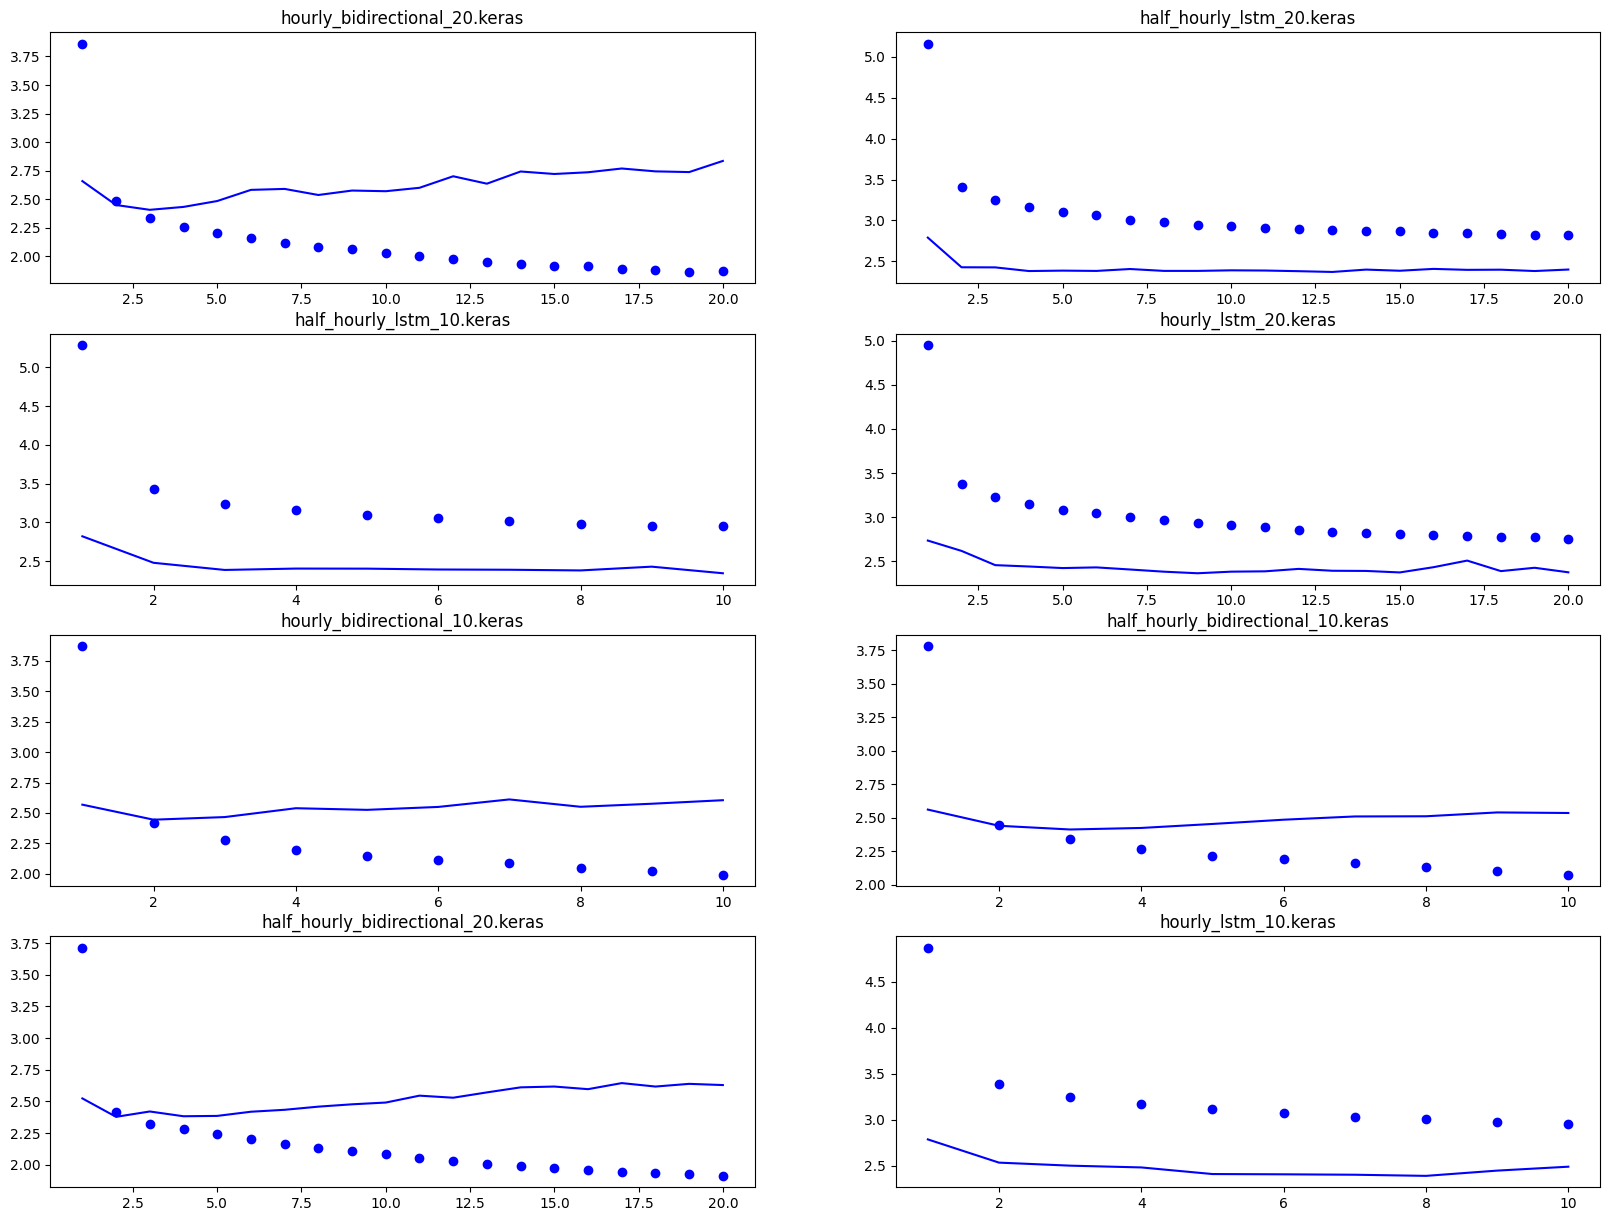

In [ ]:
i = 0
j = 0
count = 0
fig, axes = plt.subplots(int(len(histories)/2), 2, figsize=(20,15))
for key in histories:
  loss = histories[key]["mae"]
  val_loss = histories[key]["val_mae"]
  epochs = range(1, len(loss) + 1)

  axes[i][j].plot(epochs, loss, "bo", label="Training MAE")
  axes[i][j].plot(epochs, val_loss, "b", label="Validation MAE")
  axes[i][j].set_title(key)

  count += 1
  j = count % 2
  i = int(count / 2)

for key in histories:
  model = keras.models.load_model(key)
  print("MAE for ", key)
  print(f"{model.evaluate(hourly_test_dataset)[1]:.3f}")

Single step predictions. From the loaded hourly LSTM that ran for 10 epochs.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


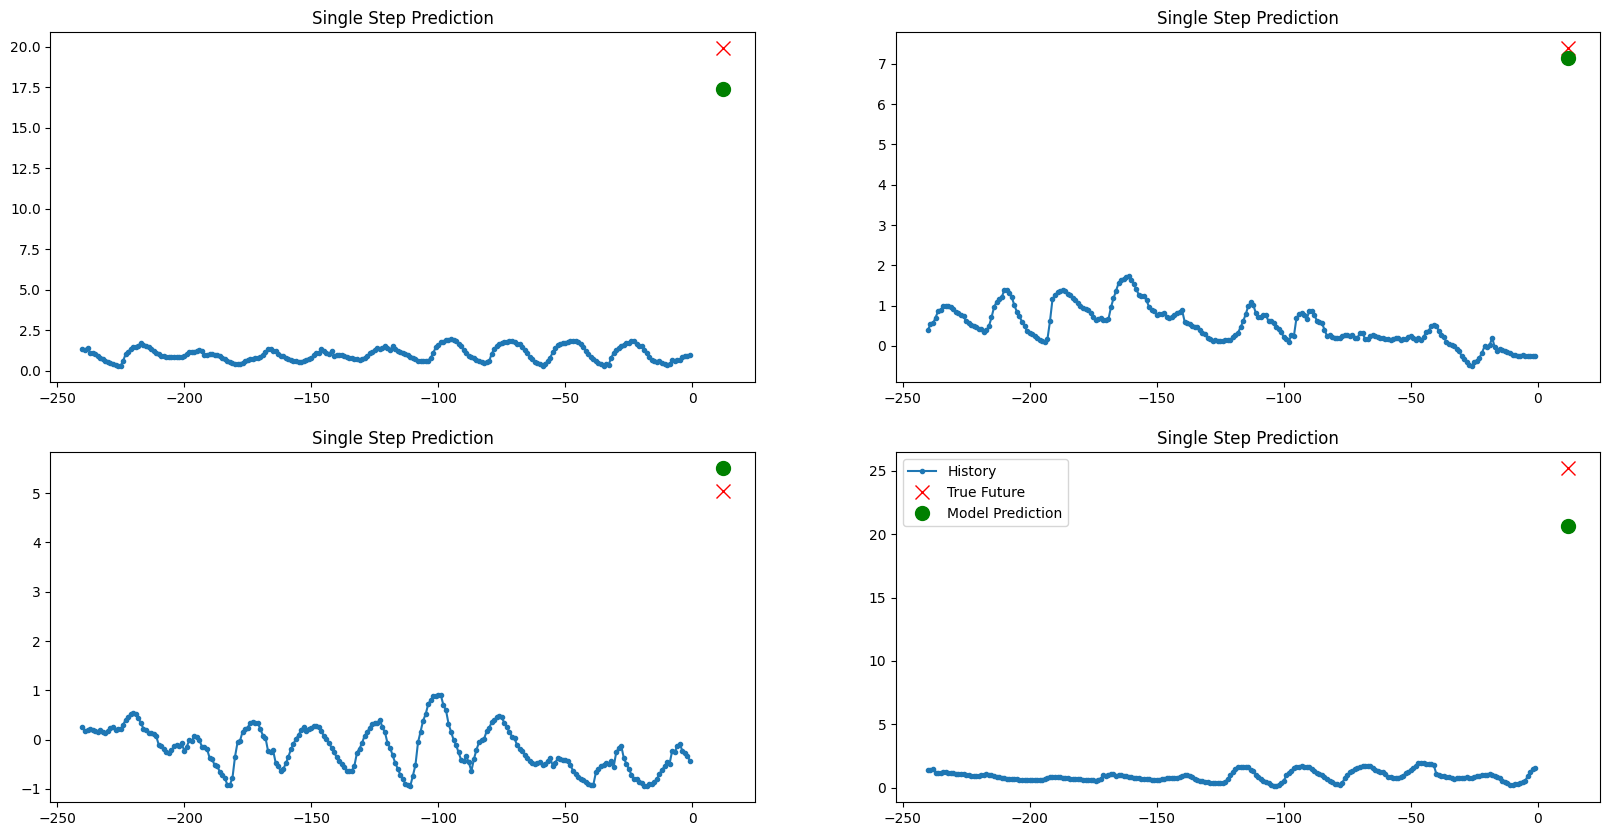

In [ ]:
model = keras.models.load_model("hourly_lstm_10.keras")

fig, axes = plt.subplots(2,2, figsize=(20,10))

u = 0
v = 0
for x, y in hourly_test_dataset.take(4):

  labels = ["History", "True Future", "Model Prediction"]
  marker = [".-", "rx", "go"]

  plot_data = [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]]

  time_steps = list(range(-(plot_data[0].shape[0]), 0))

  axes[u][v].set_title("Single Step Prediction")

  for i, val in enumerate(plot_data):
      if i:
          axes[u][v].plot(12, plot_data[i], marker[i], markersize=10, label=labels[i])
      else:
          axes[u][v].plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

  if v == 0:
    v += 1
  else:
    if u == 0:
      v = 0
      u += 1

plt.legend()
plt.show()